# Project Description
<!-- In this notebook I will visualize the similarities of two kinds of books. The two kinds of books I am chossing to compare are cook books and gothic/horror books. I am going to visualize both these books by graphing them. -->

# The Data
To demonstrate this I will first start by using a small dataset that I created. The data can be found in the `./data/csv` folder. It consists of two columns (word, label). Here are two examples `word=love,label=positive, word=hate,label=negative`. I will put this through the bert model to get an embedding and then use a dimensionalty reduction algorithm to plot each word.  

Later on I will be using book data. This data has two columns. I got this data from [here](https://www.gutenberg.org/)

First we will import some useful tools that will help us.

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

/Users/gael/git-repos/notebooks/book_genre_detection/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# First Example

In [2]:
data = pd.read_csv('./data/csv/words.csv')

In [3]:
data.head()

,word,label
0,love,positive
1,terrific,positive
2,admired,positive
3,jolly,positive
4,brave,positive


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# tokenize every word in the dataframe
encoded_data = [tokenizer(i, return_tensors='pt') for i in data.word]

In [6]:
# Our words have been encoded into a list of ids that look like this: tensor([[ 101, 3866,  102]]). 
# 101 and 102 are for start and stop. 3866 is the id of our actual word embedding and its what we actually
# need. We will extract this later.
encoded_data[0]

{'input_ids': tensor([[ 101, 2293,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [7]:
# Get the word embedding for each word in our dataset
word_embeddings = [model(**i) for i in encoded_data]

In [8]:
word_embeddings[0].last_hidden_state.shape

torch.Size([1, 3, 768])

In [9]:
# get the last hidden state for each of the embeddings
embeddings = [i.last_hidden_state for i in word_embeddings]

In [10]:
# Get the actual word embeddings
embeddings = [i[0][1] for i in embeddings]

In [11]:
embeddings = [i.detach().numpy() for i in embeddings]

In [12]:
# Add the embeddings to our dataframe
data['word_embeddings'] = embeddings

# Visualizing

Before we care able to visualize our data. we see below that the word_embeddings are huge vectors. This means we can't visulize this so we are going to use a dimensionality reduction algorithm. For this I am going to use PCA (principal component analysis) to reduce the dimension to two. 

In [13]:
data.head()

,word,label,word_embeddings
0,love,positive,"[0.38649088, 0.36188114, 0.23423344, -0.395798..."
1,terrific,positive,"[0.33330074, -0.20869645, -0.1652221, -0.06318..."
2,admired,positive,"[-0.25650117, 0.022439487, 0.25480837, -0.0880..."
3,jolly,positive,"[-0.22022378, -0.20243269, 0.10135959, -0.3264..."
4,brave,positive,"[-0.08306722, -0.11899652, -0.46022692, -0.438..."


In [14]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(list(data.word_embeddings))
principal_df = pd.DataFrame(data = principal_components, columns=['pc_one', 'pc_two'])

In [15]:
principal_df.head()

,pc_one,pc_two
0,1.714285,0.511766
1,-0.681742,-3.310150
2,-1.780253,0.753348
3,-3.881724,-0.769091
4,-2.737804,0.931430


In [16]:
# add our reduced data to our main dataframe
data = pd.concat([data, principal_df], axis=1)

In [17]:
data.head()

,word,label,word_embeddings,pc_one,pc_two
0,love,positive,"[0.38649088, 0.36188114, 0.23423344, -0.395798...",1.714285,0.511766
1,terrific,positive,"[0.33330074, -0.20869645, -0.1652221, -0.06318...",-0.681742,-3.310150
2,admired,positive,"[-0.25650117, 0.022439487, 0.25480837, -0.0880...",-1.780253,0.753348
3,jolly,positive,"[-0.22022378, -0.20243269, 0.10135959, -0.3264...",-3.881724,-0.769091
4,brave,positive,"[-0.08306722, -0.11899652, -0.46022692, -0.438...",-2.737804,0.931430


In [18]:
# split the words by label
positive = data.query('label.str.contains("positive")', engine='python')
negative = data.query('label.str.contains("negative")', engine='python')

<!-- Below we is a graph of our words graphed. We can see that the positive words are on the upper left of the chart and the negative words are in the middle to the right of the positive words. We can also see that they slightly overlap in the middle. We can also see that there are words that -->

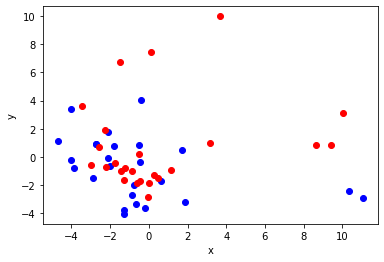

In [19]:
plt.scatter(positive.pc_one, positive.pc_two, color='b')
plt.scatter(negative.pc_one, negative.pc_two, color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show();

In [20]:
def compare_words(data):
    """
    Function to compare a word to other words in a pandas dataframe.
    """
    similarities = {}
    for i in range(len(data)):
        current_embedding = data.loc[i].word_embeddings.reshape(1, -1)
        current_word = data.loc[i].word
        most_similar = 0
        for j in range(len(data)):
            other_embedding = data.loc[j].word_embeddings.reshape(1, -1)
            other_word = data.loc[j].word
            similarity = cosine_similarity(current_embedding, other_embedding)
            if similarity >= most_similar and current_word != other_word:
                similarities[current_word] = other_word
                most_similar = similarity
    return similarities

In [21]:
similarities = compare_words(data)

In [22]:
similarities

{'love': 'hate',
 'terrific': 'wonderful',
 'admired': 'courageous',
 'jolly': 'lively',
 'brave': 'courageous',
 'fun': 'nice',
 'engaged': 'courageous',
 'happy': 'sad',
 'wonderful': 'amazing',
 'hopeful': 'frustrated',
 'free': 'frustrated',
 'confident': 'frustrated',
 'secure': 'confident',
 'lively': 'jolly',
 'amazing': 'awesome',
 'friendly': 'failure',
 'awesome': 'amazing',
 'beautiful': 'amazing',
 'kind': 'frustrated',
 'strong': 'helpless',
 'joyful': 'happy',
 'courageous': 'brave',
 'carefree': 'joyful',
 'nice': 'strong',
 'rejected': 'admired',
 'afraid': 'scared',
 'regretful': 'displeased',
 'coward': 'helpless',
 'embarrassed': 'disgusted',
 'sad': 'lonely',
 'lonely': 'frustrated',
 'alone': 'lonely',
 'displeased': 'disgusted',
 'panic': 'terrified',
 'terrified': 'scared',
 'loser': 'failure',
 'frustrated': 'scared',
 'lost': 'loser',
 'feeble': 'displeased',
 'failure': 'rejected',
 'helpless': 'terrified',
 'disgusted': 'embarrassed',
 'ugly': 'disgusting',
 

# Using the Book Dataset

In [23]:
df = pd.read_csv('./data/csv/data.csv')

In [24]:
df

,book,words
0,./data/cook_book_one.txt,project gutenberg's the whitehouse cookbook by...
1,./data/cook_book_three.txt,the project gutenberg ebook of new royal cook ...
2,./data/gothic_novel_four.txt,the project gutenberg ebook of the works of ed...
3,./data/gothic_novel_six.txt,the project gutenberg ebook of northanger abbe...
4,./data/gothic_novel_two.txt,project gutenberg’s the complete works of will...
5,./data/gothic_novel_three.txt,the project gutenberg ebook of dracula by bram...
6,./data/cook_book_four.txt,the project gutenberg ebook of the italian coo...
7,./data/gothic_novel_ten.txt,the project gutenberg ebook of the castle of o...
8,./data/gothic_novel_eight.txt,the project gutenberg ebook of the vampyre a t...
9,./data/gothic_novel_nine.txt,the project gutenberg ebook of the masque of t...
